In [23]:
import pandas as pd
from pycaret.clustering import *

from http.server import SimpleHTTPRequestHandler, HTTPServer
from urllib import request, error
import urllib.parse
import sys

badWords=['sleep','drop','uid','select','waitfor','delay','system','union','group by','order by','version','benchmark','INJ','ECT','xxx','admin']
badCharacters=['single_q','double_q','dashes','braces','spaces','at_sign','braces2']
def extractFeatures(path_enc):
    path=urllib.parse.unquote(path_enc)
    badWords_count={badWords_key:0 for badWords_key in badWords}
    single_q=path.count("'")
    double_q=path.count("\"")
    dashes=path.count("--")
    braces=path.count("(")
    spaces=path.count(" ")
    at_sign=path.count("@")
    braces2=path.count(")")
    for word in badWords:
        badWords_count[word]+=path.count(word)
    data_list=[single_q,double_q,dashes,braces,spaces,at_sign,braces2]+list(badWords_count.values())
    print(data_list)
    return pd.DataFrame([data_list],columns=badCharacters+badWords)



data=pd.read_csv(r'C:\Master\An1\sem2\Cyber Security\Project\ExtendedClusterDataset\ExtendedClusteringDataset.csv')
#data=pd.read_excel('C:\Master\An1\sem2\Cyber Security\Project\Dataset\Dataset.xlsx')
cluster1=setup(data=data,normalize=True,numeric_features=badCharacters+badWords,ignore_features=['method','path','body','type'])

cluster_firewall=create_model('kmeans',num_clusters=2,max_iter=10000)
#plot_model(cluster_firewall)
#plot_model(cluster_firewall, plot='tsne')

firewall_result=assign_model(cluster_firewall)

firewall_result.to_csv('C:\Master\An1\sem2\Cyber Security\Project\ExtendedClusterDataset\Clustering_result.csv')


,Description,Value
0,Session id,8706
1,Original data shape,"(9832, 27)"
2,Transformed data shape,"(9832, 23)"
3,Ignore features,4
4,Numeric features,23
5,Rows with missing values,92.3%
6,Preprocess,True
7,Imputation type,simple
8,Numeric imputation,mean
9,Categorical imputation,mode


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7271,1906.3963,1.3945,0,0,0


In [ ]:
class MyHTTPProxy(SimpleHTTPRequestHandler):
    proxy_routes={}

    @classmethod
    def set_routes(cls,proxy_routes):
        cls.proxy_routes=proxy_routes

    def do_GET(self):
        parts=self.path.split('/')
        print(parts)
        live_data=extractFeatures(parts[3])
        result=predict_model(cluster_firewall,data=live_data)
        print(result['Cluster'][0])
        if result['Cluster'][0]=="Cluster 1":
            print("Malicious HTTP request")
        if len(parts)>=2:
            self.proxy_request("http://"+parts[2]+"/")
        else:
            super().do_GET()

    def proxy_request(self,url):
        try:
            response=request.urlopen(url)
        except error.HTTPError as err:
            print('error')
            self.send_response_only(err.code)
            self.end_headers()
            return
        self.send_response_only(response.status)
        for name, value in response.headers.items():
            self.send_header(name, value)
        self.end_headers()
        self.copyfile(response,self.wfile)

MyHTTPProxy.set_routes({'proxy_route':'http://demo.testfire.net/'})
with HTTPServer(('127.0.0.1',8080),MyHTTPProxy) as httpd:
    host, port=httpd.socket.getsockname()
    print(f'Listening on http://{host}:{port}')
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:
        print('Proxy was stopped by KeyboardInterrupt')

Listening on http://127.0.0.1:8080


127.0.0.1 - - [04/Jun/2024 22:19:35] code 501, message Unsupported method ('CONNECT')
127.0.0.1 - - [04/Jun/2024 22:19:35] "CONNECT contile.services.mozilla.com:443 HTTP/1.1" 501 -
127.0.0.1 - - [04/Jun/2024 22:19:35] code 501, message Unsupported method ('CONNECT')
127.0.0.1 - - [04/Jun/2024 22:19:35] "CONNECT spocs.getpocket.com:443 HTTP/1.1" 501 -


['http:', '', 'detectportal.firefox.com', 'canonical.html']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Cluster 0
['http:', '', 'detectportal.firefox.com', 'canonical.html']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Cluster 0
['http:', '', 'demo.testfire.net', 'search.jsp?query=%22%29%29%3Bwaitfor+delay+%270%3A0%3A5%27--']
[2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Cluster 1
Malicious HTTP request
['http:', '', 'detectportal.firefox.com', 'canonical.html']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Cluster 0
['http:', '', 'detectportal.firefox.com', 'canonical.html']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Cluster 0


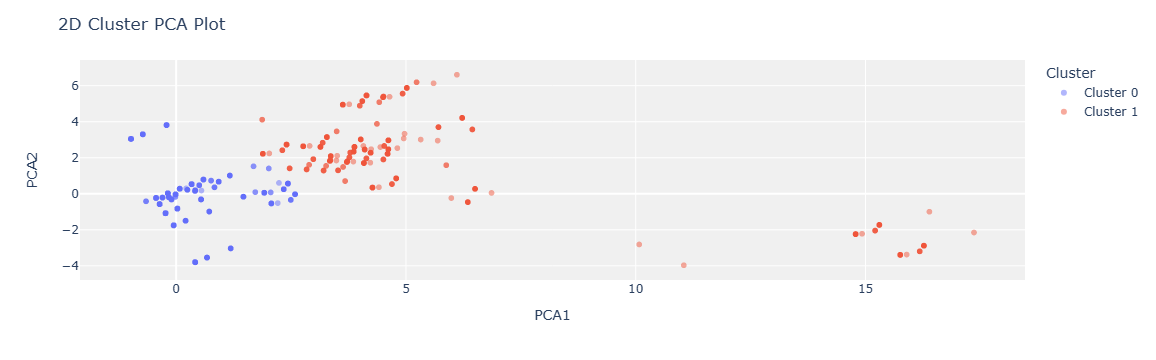

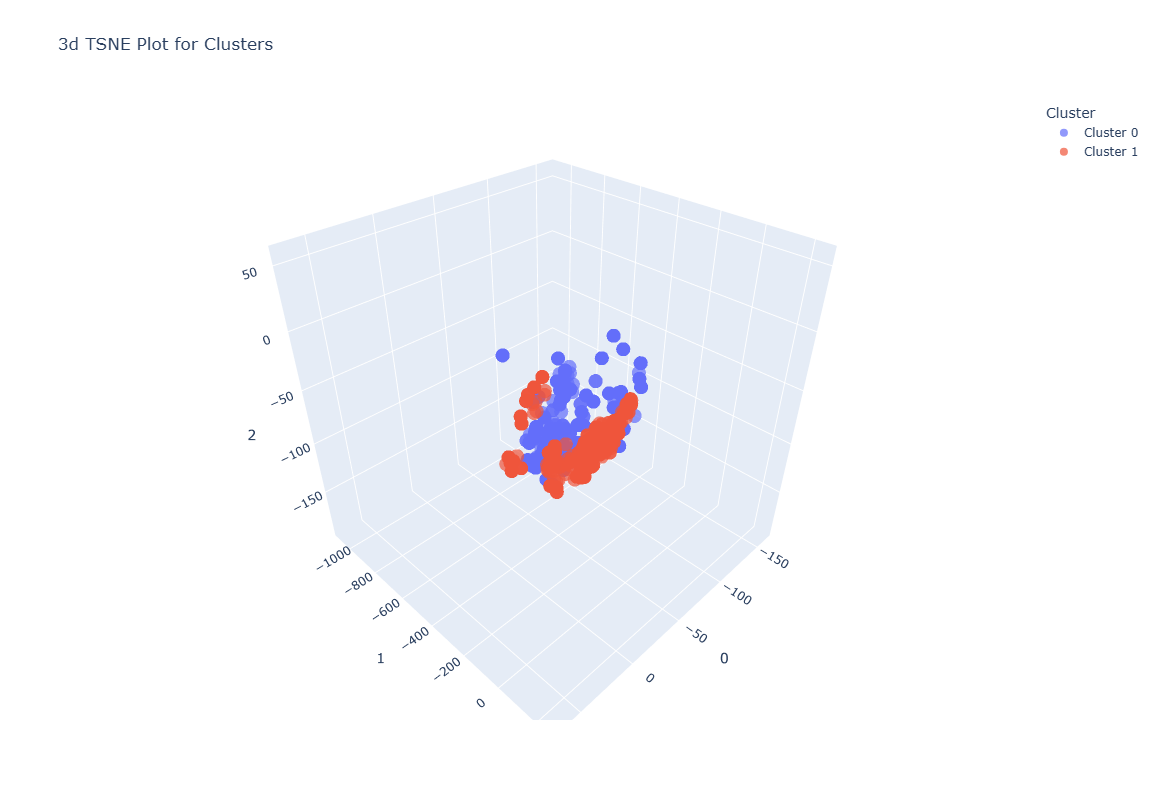

In [13]:
plot_model(cluster_firewall)
plot_model(cluster_firewall, plot='tsne')